<a href="https://colab.research.google.com/github/DataAnalystPL/Data_analysis/blob/main/Chicago_Taxi_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago taxi services in 2022


## 1. Installation and import of Packages

In [20]:
!nvidia-smi

Fri Dec  1 11:49:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 400 (delta 95), reused 52 (delta 51), pack-reused 269
Receiving objects: 100% (400/400), 109.76 KiB | 857.00 KiB/s, done.
Resolving deltas: 100% (197/197), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
pip install pyarrow==12.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 12.0.0 which is incompatible.


In [1]:
import cudf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import folium

## 2. Connecting to database

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Taxi/Taxi_Trips_-_2022_20231107.csv'

In [4]:
df = cudf.read_csv(file_path)

## 3. Basic EDA

In [5]:
# First 5 rows of the dataset:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a28...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,152,0.10,<NA>,<NA>,<NA>,<NA>,...,0.0,3.75,Cash,Medallion Leasin,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2360,17.44,<NA>,<NA>,<NA>,8,...,5.0,52.75,Cash,Flash Cab,<NA>,<NA>,<NA>,41.89960211,-87.63330804,POINT (-87.6333080367 41.899602111)
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f41...,01/01/2022 12:00:00 AM,01/01/2022 12:00:00 AM,536,4.83,<NA>,<NA>,28,22,...,0.0,14.75,Cash,Globe Taxi,41.87400538,-87.66351755,POINT (-87.6635175498 41.874005383),41.92276062,-87.69915534,POINT (-87.6991553432 41.9227606205)
3,7125b9e03a0f16c2dfb5eaf73ed057dc51eb68ef,8eca35a570101ad24c638f1f43eecce9d0cb7843e13a75...,01/01/2022 12:00:00 AM,01/01/2022 12:15:00 AM,897,2.07,<NA>,<NA>,8,32,...,1.5,11.25,Cash,Sun Taxi,41.89960211,-87.63330804,POINT (-87.6333080367 41.899602111),41.87886558,-87.62519214,POINT (-87.6251921424 41.8788655841)
4,f1a650ee419b4e52d766432e6f86eca3457bfb37,e2d8418fcdb061eee0a4318fba0a6a1200aaff0143feb0...,01/01/2022 12:00:00 AM,01/01/2022 12:30:00 AM,2200,2.48,<NA>,<NA>,8,32,...,0.0,11.50,Mobile,Chicago Independents,41.89960211,-87.63330804,POINT (-87.6333080367 41.899602111),41.87886558,-87.62519214,POINT (-87.6251921424 41.8788655841)


In [6]:
df.shape

(6382425, 23)

In [8]:
# Summary statistics
df.describe(datetime_is_numeric=True)

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,6.380960e+06,6.382369e+06,2.623831e+06,2.675331e+06,5.868572e+06,5.748741e+06,6.378889e+06,6.378889e+06,6.378889e+06,6.378889e+06,6.378889e+06,5.870874e+06,5.870874e+06,5.784494e+06,5.784494e+06
mean,1.198209e+03,6.185569e+00,1.703147e+10,1.703141e+10,3.235048e+01,2.584317e+01,2.172931e+01,2.754555e+00,2.128400e-02,2.163036e+00,2.682510e+01,4.189992e+01,-8.768816e+01,4.189471e+01,-8.766249e+01
std,1.895665e+03,8.002858e+00,3.689458e+05,3.457735e+05,2.520304e+01,2.092543e+01,4.941624e+01,4.083892e+00,7.659939e+00,2.175269e+01,5.696460e+01,6.015100e-02,1.047000e-01,5.620700e-02,7.332000e-02
min,0.000000e+00,0.000000e+00,1.703101e+10,1.703101e+10,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.165192e+01,-8.791362e+01,4.166014e+01,-8.791362e+01
25%,4.580000e+02,8.500000e-01,1.703108e+10,1.703108e+10,8.000000e+00,8.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.990000e+00,4.187887e+01,-8.768384e+01,4.187887e+01,-8.766352e+01
50%,8.620000e+02,2.600000e+00,1.703132e+10,1.703132e+10,3.200000e+01,2.800000e+01,1.400000e+01,9.200000e-01,0.000000e+00,0.000000e+00,1.700000e+01,4.189322e+01,-8.763331e+01,4.189251e+01,-8.763331e+01
75%,1.620000e+03,1.110000e+01,1.703184e+10,1.703184e+10,4.400000e+01,3.200000e+01,3.325000e+01,4.000000e+00,0.000000e+00,2.000000e+00,4.050000e+01,4.194423e+01,-8.762519e+01,4.192269e+01,-8.762519e+01
max,8.634100e+04,2.967540e+03,1.703198e+10,1.703198e+10,7.700000e+01,7.700000e+01,9.999750e+03,4.960000e+02,6.666660e+03,8.888880e+03,9.999750e+03,4.202122e+01,-8.753071e+01,4.202122e+01,-8.753139e+01


In [9]:
# Data types of each column
df.dtypes

Trip ID                        object
Taxi ID                        object
Trip Start Timestamp           object
Trip End Timestamp             object
Trip Seconds                    int64
Trip Miles                    float64
Pickup Census Tract             int64
Dropoff Census Tract            int64
Pickup Community Area           int64
Dropoff Community Area          int64
Fare                          float64
Tips                          float64
Tolls                         float64
Extras                        float64
Trip Total                    float64
Payment Type                   object
Company                        object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location       object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location     object
dtype: object

In [10]:
# Number of missing values in each column
df.isnull().sum()

Trip ID                             0
Taxi ID                           354
Trip Start Timestamp                0
Trip End Timestamp                212
Trip Seconds                     1465
Trip Miles                         56
Pickup Census Tract           3758594
Dropoff Census Tract          3707094
Pickup Community Area          513853
Dropoff Community Area         633684
Fare                             3536
Tips                             3536
Tolls                            3536
Extras                           3536
Trip Total                       3536
Payment Type                        0
Company                             0
Pickup Centroid Latitude       511551
Pickup Centroid Longitude      511551
Pickup Centroid Location       511551
Dropoff Centroid Latitude      597931
Dropoff Centroid Longitude     597931
Dropoff Centroid  Location     597931
dtype: int64

## 4. Cleaning Dataset

In [11]:
# Droping empty and columns with 0 values or useless
col_to_drop = ["Pickup Census Tract", "Dropoff Census Tract", "Pickup Centroid Location" , "Dropoff Centroid  Location"]
df.drop(col_to_drop, axis=1, inplace=True)

In [12]:
columns_to_clean = ['Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Extras', 'Trip Total', 'Tolls']
# Droping empty rows
for column in columns_to_clean:
  df.dropna(subset=column, inplace=True)

In [13]:
df.isnull().sum()

Trip ID                            0
Taxi ID                            0
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Pickup Community Area         512639
Dropoff Community Area        632344
Fare                               0
Tips                               0
Tolls                              0
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude      510345
Pickup Centroid Longitude     510345
Dropoff Centroid Latitude     596625
Dropoff Centroid Longitude    596625
dtype: int64

# 5. Cleaning timestamps

In [15]:
df['Trip Start Timestamp'] = cudf.to_datetime(df['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')
df['Trip End Timestamp'] = cudf.to_datetime(df['Trip End Timestamp'], format='%m/%d/%Y %I:%M:%S %p').dt.strftime('%Y-%m-%d %H:%M:%S')

## 5. EDA

In [16]:
import matplotlib
matplotlib.style.use('ggplot')

In [17]:
palette = ['#367C6E', '#EECD69', '#F3AC59', '#954C41', '#E56F3E']

In [28]:
df_to_plot = df.to_pandas()

### 1. Taxi Companies info

In [93]:
#How many taxi companies do we have in the database?
taxi_companies = df['Company'].unique().to_pandas()

In [94]:
print(f"We have {len(taxi_companies)} taxi companies:")
for row in taxi_companies:
  print("\t- ", row)

We have 37 taxi companies:
	-  Medallion Leasin
	-  Flash Cab
	-  Globe Taxi
	-  Sun Taxi
	-  Chicago Independents
	-  City Service
	-  Taxi Affiliation Services
	-  Top Cab Affiliation
	-  Choice Taxi Association
	-  Taxicab Insurance Agency, LLC
	-  24 Seven Taxi
	-  Patriot Taxi Dba Peace Taxi Associat
	-  Blue Ribbon Taxi Association Inc.
	-  U Taxicab
	-  Setare Inc
	-  312 Medallion Management Corp
	-  KOAM Taxi Association
	-  Chicago Taxicab
	-  Petani Cab Corp
	-  2733 - 74600 Benny Jona
	-  3620 - 52292 David K. Cab Corp.
	-  Metro Jet Taxi A.
	-  3556 - 36214 RC Andrews Cab
	-  4053 - 40193 Adwar H. Nikola
	-  4787 - 56058 Reny Cab Co
	-  Chicago Carriage Cab Corp
	-  Taxicab Insurance Agency Llc
	-  Top Cab
	-  6574 - Babylon Express Inc.
	-  4623 - 27290 Jay Kim
	-  Nova Taxi Affiliation Llc
	-  Blue Ribbon Taxi Association
	-  Star North Taxi Management Llc
	-  Koam Taxi Association
	-  5062 - 34841 Sam Mestas
	-  5 Star Taxi
	-  Leonard Cab Co


In [95]:
#How many Trips each company made?
trip_count_by_company = df.groupby('Company').size().sort_values(ascending=False)
print(trip_count_by_company)

Company
Flash Cab                               1406011
Taxi Affiliation Services               1325524
Sun Taxi                                 717838
City Service                             587808
Chicago Independents                     328276
Taxicab Insurance Agency Llc             284228
Medallion Leasin                         266165
Taxicab Insurance Agency, LLC            264850
Globe Taxi                               241804
5 Star Taxi                              157786
Star North Taxi Management Llc           152557
Blue Ribbon Taxi Association             151942
Choice Taxi Association                  126597
Top Cab Affiliation                      108904
U Taxicab                                 57818
24 Seven Taxi                             55929
Blue Ribbon Taxi Association Inc.         36977
Chicago Taxicab                           24149
Patriot Taxi Dba Peace Taxi Associat      21823
Koam Taxi Association                     12909
312 Medallion Management Corp   

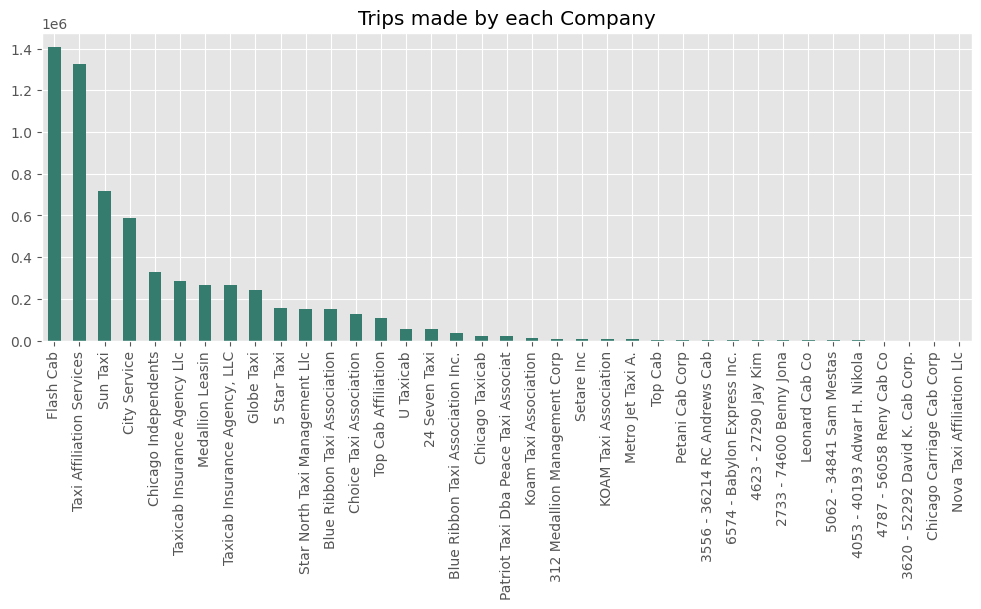

In [96]:
df_to_plot['Company'].value_counts().plot(kind='bar', figsize=(12,4), title='Trips made by each Company', color=palette[0])
plt.show()

In [99]:
#How many miles each company made?
miles_per_company = df.groupby('Company')['Trip Miles'].sum().sort_values(ascending=False).to_pandas()
print(miles_per_company.round(2))

Company
Flash Cab                               9141929.80
Taxi Affiliation Services               5342499.00
Sun Taxi                                4992774.31
City Service                            4127291.59
Chicago Independents                    2304801.71
Taxicab Insurance Agency Llc            1855451.59
Medallion Leasin                        1834841.96
Taxicab Insurance Agency, LLC           1748045.90
Globe Taxi                              1592866.65
Star North Taxi Management Llc          1153955.45
5 Star Taxi                             1092898.57
Choice Taxi Association                  915624.50
Blue Ribbon Taxi Association             900933.74
Top Cab Affiliation                      774387.20
U Taxicab                                481574.50
24 Seven Taxi                            303277.23
Chicago Taxicab                          193022.68
Blue Ribbon Taxi Association Inc.        130847.40
Patriot Taxi Dba Peace Taxi Associat      91810.14
312 Medallion Managemen

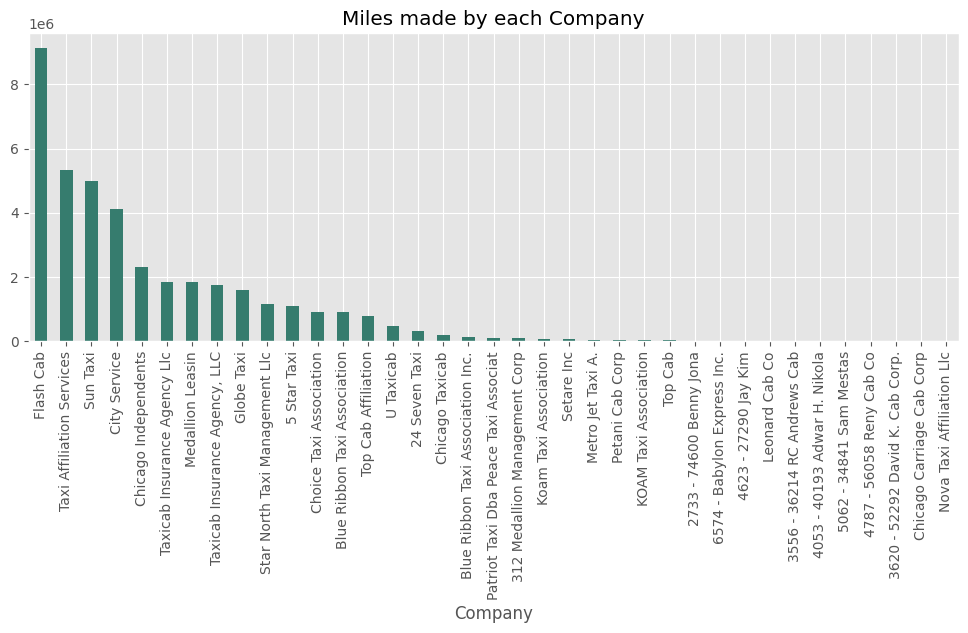

In [100]:
miles_per_company.plot(kind='bar', figsize=(12,4), title='Miles made by each Company', color=palette[0])
plt.show()

In [101]:
#How much each company earned for all fares?
fare_per_company = df.groupby(df['Company'])['Fare'].sum().sort_values(ascending=False).to_pandas()
print(fare_per_company.round(2))

Company
Flash Cab                               30802118.03
Taxi Affiliation Services               27346035.87
Sun Taxi                                15414653.15
City Service                            12681291.80
Chicago Independents                     7137337.46
Taxicab Insurance Agency, LLC            6043128.88
Taxicab Insurance Agency Llc             5897331.88
Medallion Leasin                         5561937.06
Globe Taxi                               5027314.32
5 Star Taxi                              3627267.17
Star North Taxi Management Llc           3461799.03
Blue Ribbon Taxi Association             2932966.39
Choice Taxi Association                  2760115.19
Top Cab Affiliation                      2326319.54
Metro Jet Taxi A.                        2212204.06
U Taxicab                                1411798.95
24 Seven Taxi                             992593.47
Chicago Taxicab                           690053.05
Blue Ribbon Taxi Association Inc.         598761.24
Patr

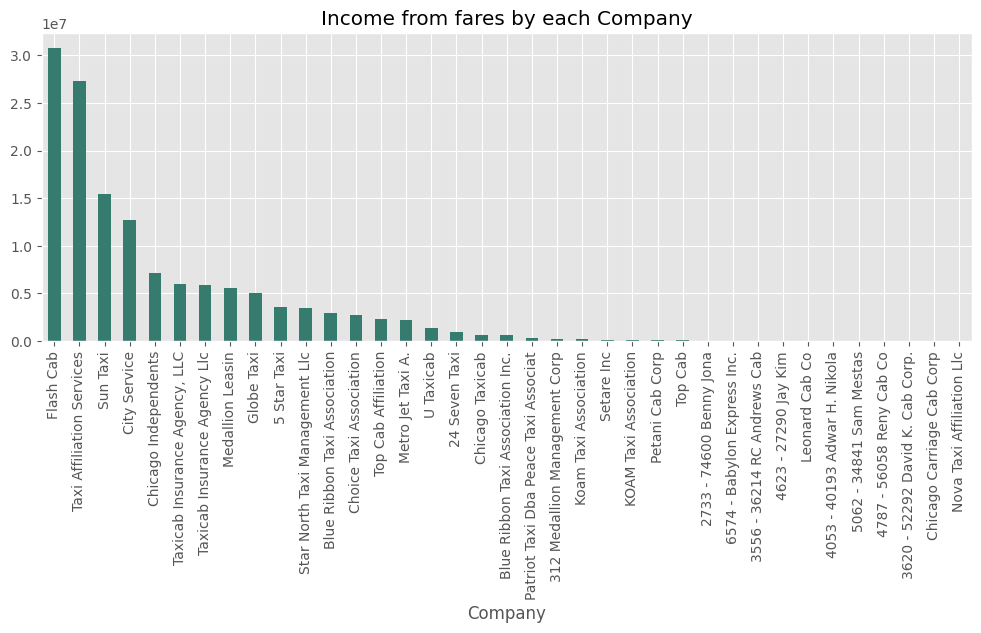

In [102]:
fare_per_company.plot(kind='bar', figsize=(12,4), title='Income from fares by each Company', color=palette[0])
plt.show()

In [103]:
#How much each company earned for all tips?
tips_per_company = df.groupby(df['Company'])['Tips'].sum().sort_values(ascending=False).to_pandas()
print(tips_per_company.round(2))

Company
Taxi Affiliation Services               3201435.09
Sun Taxi                                2536052.21
Flash Cab                               2404646.22
City Service                            1921108.84
Chicago Independents                    1189322.13
Taxicab Insurance Agency Llc             943919.71
Taxicab Insurance Agency, LLC            903853.70
Medallion Leasin                         816999.15
Globe Taxi                               748991.87
Star North Taxi Management Llc           530112.58
5 Star Taxi                              454378.89
Choice Taxi Association                  431398.38
Blue Ribbon Taxi Association             372077.93
Top Cab Affiliation                      365878.94
U Taxicab                                205270.80
24 Seven Taxi                            163754.82
Chicago Taxicab                           81682.09
Blue Ribbon Taxi Association Inc.         61907.23
312 Medallion Management Corp             40554.44
Koam Taxi Association  

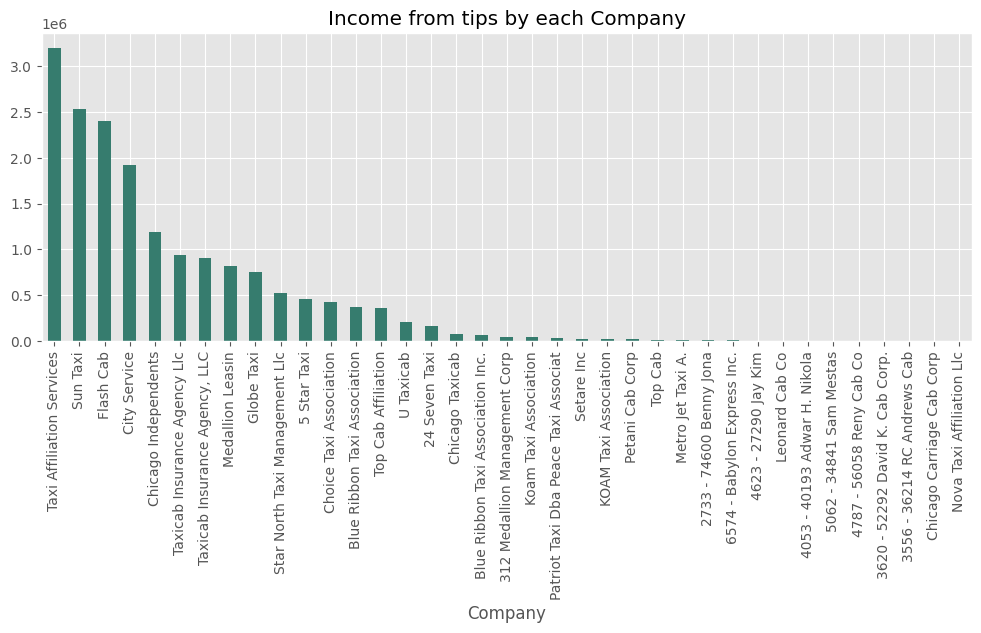

In [104]:
tips_per_company.plot(kind='bar', figsize=(12,4), title='Income from tips by each Company', color=palette[0])
plt.show()

In [105]:
#How much each company earned for all tolls?
tolls_per_company = df.groupby(df['Company'])['Tolls'].sum().sort_values(ascending=False).to_pandas()
print(tolls_per_company)

Company
Taxi Affiliation Services               91503.71
Taxicab Insurance Agency, LLC            8632.63
Taxicab Insurance Agency Llc             5321.22
Chicago Independents                     5012.38
Sun Taxi                                 3806.21
City Service                             3729.77
Star North Taxi Management Llc           3380.92
Globe Taxi                               3362.68
Medallion Leasin                         3023.96
Choice Taxi Association                  2919.98
Top Cab Affiliation                      1766.26
U Taxicab                                1612.35
Blue Ribbon Taxi Association             1360.17
Koam Taxi Association                     154.94
Chicago Taxicab                            54.52
Flash Cab                                  43.75
5 Star Taxi                                37.00
Petani Cab Corp                            15.00
Top Cab                                    15.00
312 Medallion Management Corp              14.50
KOAM Taxi As

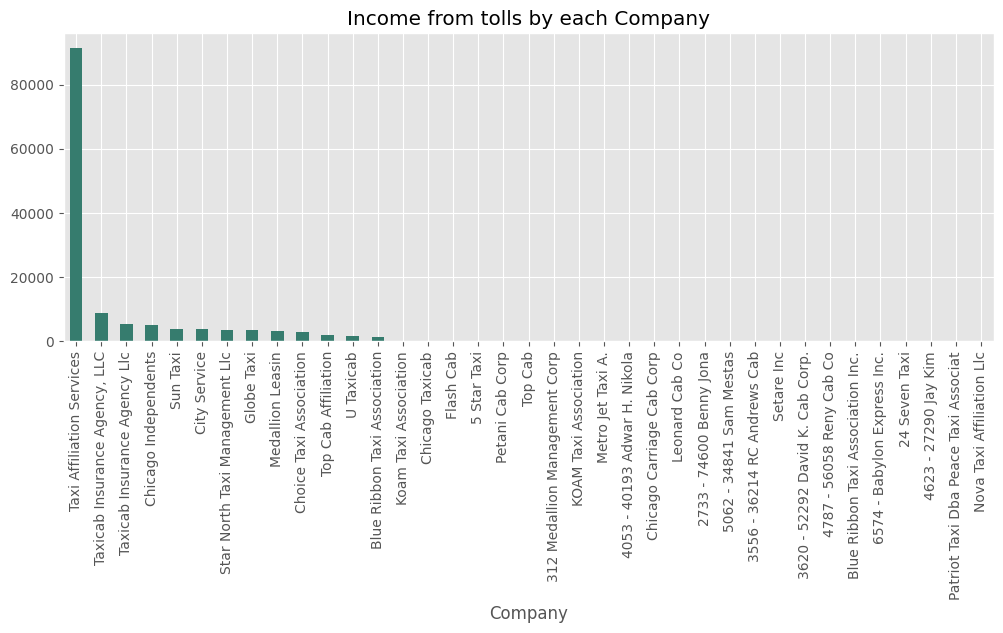

In [107]:
tolls_per_company.plot(kind='bar', figsize=(12,4), title='Income from tolls by each Company', color=palette[0])
plt.show()

In [108]:
#How much each company earned for all extras?
extras_per_company = df.groupby(df['Company'])['Extras'].sum().sort_values(ascending=False).to_pandas()
print(extras_per_company)

Company
Taxi Affiliation Services               3527614.60
Sun Taxi                                1598401.02
Flash Cab                               1577990.50
City Service                            1218211.05
Taxicab Insurance Agency, LLC            866060.18
Chicago Independents                     843392.47
Medallion Leasin                         652972.53
Taxicab Insurance Agency Llc             649192.62
Globe Taxi                               545455.87
Star North Taxi Management Llc           402662.65
Choice Taxi Association                  360685.14
Top Cab Affiliation                      355218.63
5 Star Taxi                              340059.00
Blue Ribbon Taxi Association             215540.47
U Taxicab                                205694.26
24 Seven Taxi                             82883.50
Chicago Taxicab                           81504.32
Blue Ribbon Taxi Association Inc.         59823.56
312 Medallion Management Corp             44455.51
Setare Inc             

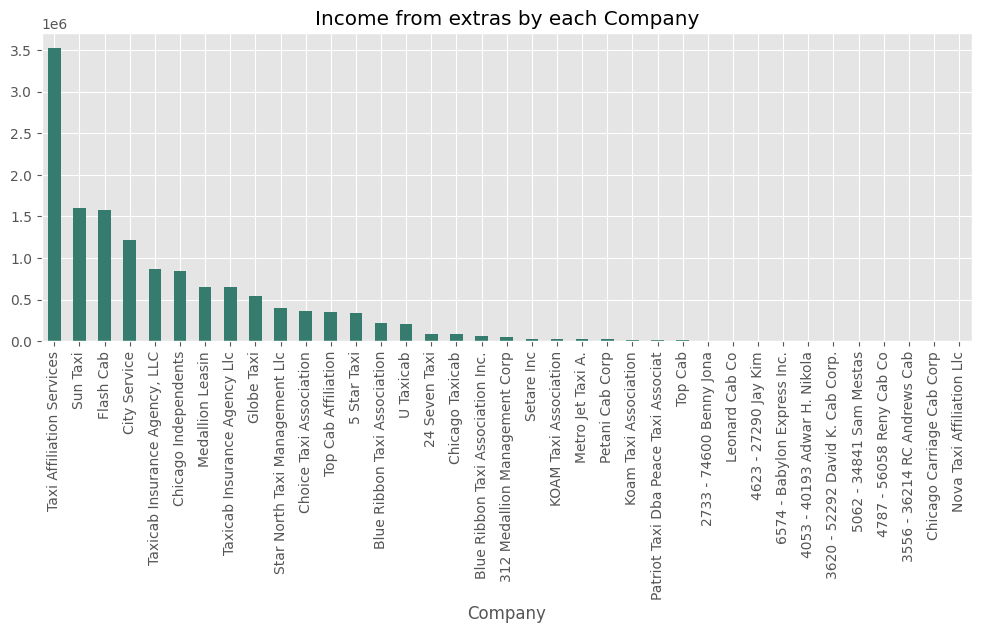

In [109]:
extras_per_company.plot(kind='bar', figsize=(12,4), title='Income from extras by each Company', color=palette[0])
plt.show()

In [110]:
#How much each company earned in total?
earnings_per_company = df.groupby(df['Company'])['Trip Total'].sum().sort_values(ascending=False).to_pandas()
print(earnings_per_company.round(2))

Company
Flash Cab                               34966842.88
Taxi Affiliation Services               34166589.87
Sun Taxi                                19762369.82
City Service                            15981140.10
Chicago Independents                     9258593.44
Taxicab Insurance Agency, LLC            7821675.89
Taxicab Insurance Agency Llc             7582963.62
Medallion Leasin                         7108685.83
Globe Taxi                               6383624.87
5 Star Taxi                              4456874.14
Star North Taxi Management Llc           4443057.83
Blue Ribbon Taxi Association             3559929.69
Choice Taxi Association                  3555118.69
Top Cab Affiliation                      3049183.37
Metro Jet Taxi A.                        2247536.43
U Taxicab                                1824376.36
24 Seven Taxi                            1252914.89
Chicago Taxicab                           860203.76
Blue Ribbon Taxi Association Inc.         720492.03
Patr

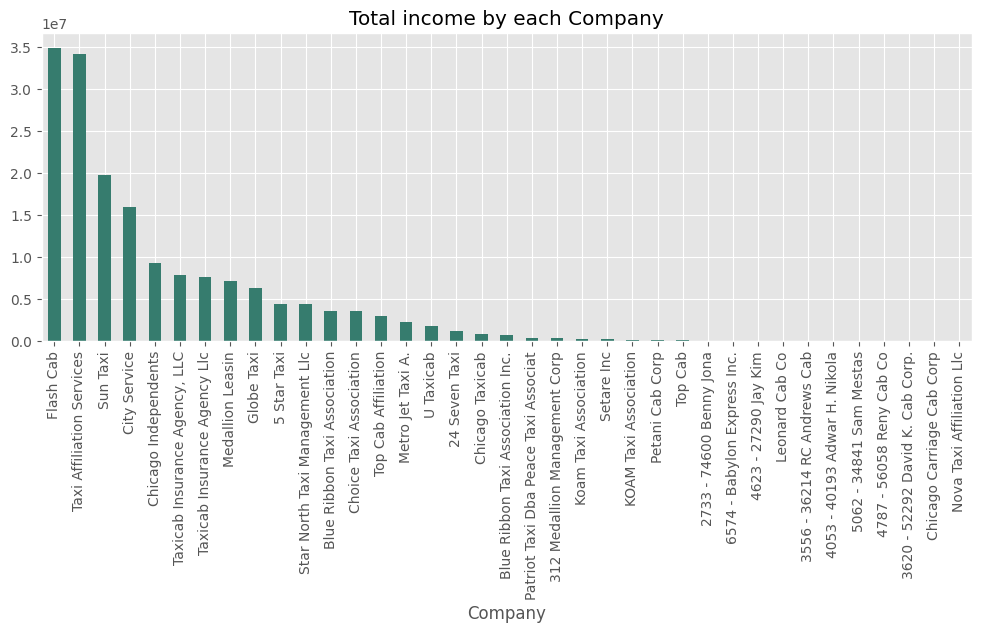

In [112]:
earnings_per_company.plot(kind='bar', figsize=(12,4), title='Total income by each Company', color=palette[0])
plt.show()

In [113]:
taxi_per_company = df.groupby('Company')['Taxi ID'].nunique().sort_values(ascending=False).to_pandas()
print(taxi_per_company)

Company
Flash Cab                               586
Taxi Affiliation Services               549
5 Star Taxi                             342
Sun Taxi                                313
City Service                            291
Taxicab Insurance Agency Llc            231
Chicago Independents                    203
Taxicab Insurance Agency, LLC           195
Medallion Leasin                        146
Blue Ribbon Taxi Association            123
Globe Taxi                              121
Star North Taxi Management Llc          102
Blue Ribbon Taxi Association Inc.        84
Choice Taxi Association                  67
Top Cab Affiliation                      65
24 Seven Taxi                            36
U Taxicab                                34
Chicago Taxicab                          17
Patriot Taxi Dba Peace Taxi Associat     11
312 Medallion Management Corp             9
Koam Taxi Association                     8
KOAM Taxi Association                     7
Top Cab                 

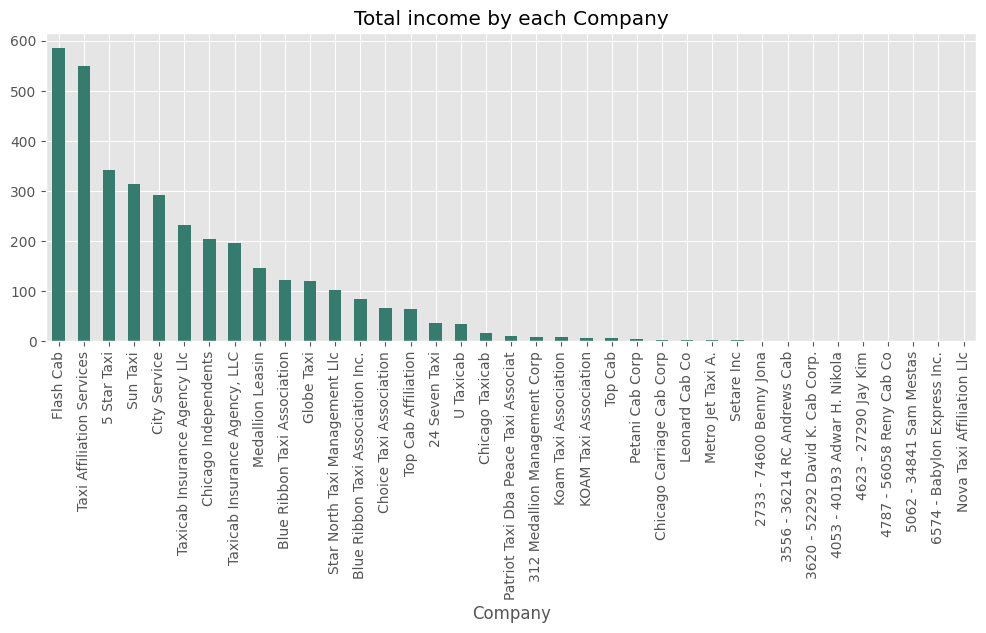

In [114]:
taxi_per_company.plot(kind='bar', figsize=(12,4), title='Total income by each Company', color=palette[0])
plt.show()

### 2. Taxi Drivers info - TO DO

In [ ]:
#How many taxis do we have in the database and how much trips make the most active one?
trip_count_by_taxi = df.groupby(['Taxi ID']).size().sort_values(ascending=False)
trip_count_by_taxi.head(10)

Taxi ID
2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba38b064d7d6f4acc260b68ef1ae3ce06dad845178107940b3493fa99640f0f70c25d15cf57336ab7b8f    9610
8da9e1d18757022c6a6a614fc2d38483e38aae441feff500095a83ebc68006cf88329f2c28e35ba92ead14037739f9971a8a2852f946ebc59d0160c4f1104ec8    8251
f98ae5e71fdda8806710af321dce58002146886c013f411be2cd336e0c224e78ed85626eeee462f0d1f5e6b29a030514b95f7b1b8ca59888a10b52dfe55ddf99    7810
3d9da170c3265c7027541b4dd1802eb22d897f005fedfa3069c7f22a02e9906887e3ef5373c9fa1fca09299d660c7ab65cf5e8c38d1e94f5fa7742a1fb11bd29    7475
8a8b7ea6cf38ddad449d266d38a1c10cf326e0e06f3e7cb89c49057621f91f8ba12186cca33bbbe5ee406c0d57a8411c6dd6cb69a3881c5b3ad508d5bb515543    7464
3b084cc9045b3afc1c8bb8b5b76921d8e41c00494b15bdfc5d1d6e7a36fd63f2dd5acf5cdff5fe483a6facb786e1de836bea1a63d992f80c410c3f05ddea9106    7386
66d3807bc1b0bcf7c3b90c19f7c13356cdd60995199804afe2355e2736bf4a56d616f7f783596da3bdcb6b755c43d8b26818486f213604c04b6ebbcd9b99abc8    7173
14685d7c19b1bcf05466194de4a62ee39

In [ ]:
print(f"We have {len(trip_count_by_taxi)} taxis and the most active one made {trip_count_by_taxi.max()} trips")

We have 2886 taxis and the most active one made 9610 trips


In [ ]:
#How many miles each taxi made?
miles_per_taxi = df.groupby('Taxi ID')['Trip Miles'].sum().sort_values(ascending=False)
miles_per_taxi.head(10)

Taxi ID
da60c0b2a94e4c516b9c9bdaceeb3f17066f98190eb3895010b6071915a64752e5cb1532dc6d36f992a6ed48287e4409110651d140ba63296c1f68f0ed853676    64625.37
a79d72d3d49bed13558577cc0608caf7e8da5b9cee67b608b53567d1be89e0ad257654a59e271e1a0239e5ef4a926668d7edb9e1a798a7b1e6726b64113518c6    62902.90
2981edd199f55bdc8b5ed188de69e9f5d8116ae8d7a434fa0574d57740840e697755e4e77bb4ce8265289b6548d53674a5ac16dde44c3cf653e3ce1c8e064265    53855.10
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4    52487.02
7e25041185a6cc504dd6e2f71691c595aeae45c4b862473f016bed34ee33e1dc9c74ab26454407ae4794086f7f1bd2e91cd5a53c98274f9efbab4e915b0460f7    51937.36
950af3418bda33a809615e29c0592a6ab8ed5f479173437b80b129e16694d099c13ac649b93c38a08e703f3bc8c11a16bf7c37ccca96824dd06c56709d6afeac    51429.37
6c862bc95ea06a072a03b188ee3f78cadbfdcffdfe64bd90514563cd31352ad477ede709ea8ad124cdd7e445fc7e1d1b807ca07f6b9f132a8b72694b7de6c782    50790.64
2af80

In [ ]:
#How much each taxi earned for all Fares?
fare_per_taxi = df.groupby('Taxi ID')['Fare'].sum().sort_values(ascending=False)
fare_per_taxi.head(10)

Taxi ID
0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a    1579401.87
da60c0b2a94e4c516b9c9bdaceeb3f17066f98190eb3895010b6071915a64752e5cb1532dc6d36f992a6ed48287e4409110651d140ba63296c1f68f0ed853676     176933.90
a79d72d3d49bed13558577cc0608caf7e8da5b9cee67b608b53567d1be89e0ad257654a59e271e1a0239e5ef4a926668d7edb9e1a798a7b1e6726b64113518c6     172768.11
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4     172613.06
12bfcfb8715a63cacb9a4bc127f622071bab27b36a8488cbeccd3b5698b3f8ea9292662b3468f8d4668f1b84f5a96d8fd4436522abad8b8994c7ad40309a1805     153087.14
14685d7c19b1bcf05466194de4a62ee39d4144f97867505373401607acec327e9b715f57d5ae38f00020eb0a6325c0923967d4cdfbefb2ed0930d80a9fcdae42     149836.00
7e25041185a6cc504dd6e2f71691c595aeae45c4b862473f016bed34ee33e1dc9c74ab26454407ae4794086f7f1bd2e91cd5a53c98274f9efbab4e915b0460f7     1

In [ ]:
print(f"That is something unusual. Taxi ID {fare_per_taxi.index[0]} earned {fare_per_taxi[0]/fare_per_taxi[1]} times more than Taxi which is on the second place.")

That is something unusual. Taxi ID 0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a earned 8.926507978403235 times more than Taxi which is on the second place.


In [ ]:
#How much each taxi earned for all Tips?
tips_per_taxi = df.groupby('Taxi ID')['Tips'].sum().sort_values(ascending=False)
tips_per_taxi.head(10)

Taxi ID
847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677eed6a0aaa4aeef61984916b32d763b4baa6c32476531543bb77e2346cd64f505618f6b9d562243f950    31637.89
252ada1a45e512d3d038a61eb1832c0eec8e3c8dce58336f73d774bea49e0f203635dbc583d2135f060a5cd63c9ea7f6ac787f546ffa0b80daabd6e39eebe4f1    19778.34
f98ae5e71fdda8806710af321dce58002146886c013f411be2cd336e0c224e78ed85626eeee462f0d1f5e6b29a030514b95f7b1b8ca59888a10b52dfe55ddf99    16947.36
2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba38b064d7d6f4acc260b68ef1ae3ce06dad845178107940b3493fa99640f0f70c25d15cf57336ab7b8f    16706.59
0cf1289b8acf557ac9673f1b9a4b544f295d83edb49af8429a57b45e0600bcfe523c7b2e8378b5b9a41550ee97cb33bc0b99ec7a73869f6e892e551bc4c2678e    16096.93
df78a9555ae5e9041d230bb2f8e1ed8386a1a2a6e52baa0fc3c66bbf9272e28ef537816479fd8556374143c5b220f4bcb05f798ce82cad9a1ee7433f9912dd6e    15836.77
c8549ac4a2842a038f2a5b91ecf894ca7cb04d60558be3dc1878baa95aeb7614775727cacfe28797dae16b233792ff6784049cd5e881a2454604a3383beb70ed    15101.96
8da9e

In [ ]:
print(f"Taxi ID {tips_per_taxi.index[0]} earned {tips_per_taxi[0]/tips_per_taxi[1]} times more than Taxi which is on the second place.")

Taxi ID 847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677eed6a0aaa4aeef61984916b32d763b4baa6c32476531543bb77e2346cd64f505618f6b9d562243f950 earned 1.5996231230730182 times more than Taxi which is on the second place.


In [ ]:
#How much each taxi earned for all Tolls?
tolls_per_taxi = df.groupby('Taxi ID')['Tolls'].sum().sort_values(ascending=False)
tolls_per_taxi.head(10)

Taxi ID
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded    46662.20
46c4778c3a32454511f96752c509c608955e293da45dbf245bf9eba5bef28916b7b61295d27aa8f61e4ad63b264051057ace630bce41b8aff5bc6853585fed15     6667.98
43df1f84886471551da759b428112545e906f7652ee5b3426c1059a390ab1bc9f47c3de0dc58108b37143c1cef8148b4f44a3df57e17bd140e464df3fbab7482     5786.76
fbfc2ff558d0fc2dd96362ef65d25e08f00b13bc427645692cc034fb62d0ccf5f19c7187554fdf79c714323023b793de64da10de48051c38528f05ca5fc29e27     5558.47
3577d72a8bf30406c1346a5e178b7f3a0ce8e1f966f59afa6b9acfd4668b779e82f3766dd3b426278a666a18a9ae5d159070e7821e06c0c00ed390eca863e001     4444.44
3c3adc53bf9361a6e6a8a08a70ac6303921220efb83a30c7589b0169c2f8bbd4f2e7e8f5f05be624f132ce6bae55577356109350764823f36b42566dd407924c     4344.34
59e1ac971265cac68229ac1e7fb8dacd4aa9d7722df16c2ffc039a515b4acacef28cb04e0edbcdf376faf44862240b2621352159d8a72a887da6f531b016a45a     4143.25
4ddcd

In [ ]:
print(f"Another unusual thing. Taxi ID {tolls_per_taxi.index[0]} earned {tolls_per_taxi[0]/tolls_per_taxi[1]} times more than Taxi which is on the second place.")

Another unusual thing. Taxi ID 53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded earned 6.997951403573496 times more than Taxi which is on the second place.


In [ ]:
#How much each taxi earned for all Extras?
extras_per_taxi = df.groupby('Taxi ID')['Extras'].sum().sort_values(ascending=False)
extras_per_taxi.head(10)

Taxi ID
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded    233719.93
fea1ad3b44e1a049eb5b1f33d9c53ddd6cae02b095b6a16c8507d94624aab8dcfcaa2eb03f45242370f1dc88ce1f9fed5fff858de8ef863a30868f68a0626773     27946.04
fdc3156afe8accb70f5aea5f2cd2d7cefd089d13b6d930151e1a195fbb53b1caf1b110ebbb901077e295080c2a5a3e1b2d2b42595435d1defd965e1604c1cf90     25452.47
4364d99b1f14eb6e63596a20a1a936c805239d09b4675e8165d9d0ab91ea565990be35225384dfb78f1bc75c4fd0ba36620ddf840f64f0403df3d2cc55c1258b     17983.45
81bc2020b8536280419b3e152ad07a0c5b9f53cbb503a0e4e2b49254d4e359759e76256dab04c95c0ed69ddb5a89ce1f45d8db67bd7fbb101f91417b4ce3d271     17389.60
223702c6155649517dcb9f4860ae0fa2669903bbe7d54fae5475cd9677fc8230ad3f1bf9721b88063fb7a3e7b153de9a2e27521d15392ae203f9b17169833607     16233.45
00752524a4118a162dce62ff49c0eb0f79530d9e0ecb5a9b0d23deae98ef2ab2bc84831d2191950da25620e550ad69840e1d02f69d49ab1d9b2b4387e31c2af1     15836.1

In [ ]:
print(f"And here is another. Taxi ID {extras_per_taxi.index[0]} earned {extras_per_taxi[0]/extras_per_taxi[1]} times more than Taxi which is on the second place.")

And here is another. Taxi ID 53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded earned 8.363257549191227 times more than Taxi which is on the second place.


In [ ]:
#How much each taxi earned in Total?
earnings_per_taxi = df.groupby('Taxi ID')['Trip Total'].sum().sort_values(ascending=False)
earnings_per_taxi.head(10)

Taxi ID
0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a    1596126.96
53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded     359988.21
da60c0b2a94e4c516b9c9bdaceeb3f17066f98190eb3895010b6071915a64752e5cb1532dc6d36f992a6ed48287e4409110651d140ba63296c1f68f0ed853676     178863.33
a79d72d3d49bed13558577cc0608caf7e8da5b9cee67b608b53567d1be89e0ad257654a59e271e1a0239e5ef4a926668d7edb9e1a798a7b1e6726b64113518c6     176485.45
356744753023949fa63be6a6d7e0aef31f2d50dd3b0258449c6b8b6d277765da6955b1ef88c72ca79a9db0d3c20b162fce7cd9ec113b49da61c12c2c546915d4     173896.91
252ada1a45e512d3d038a61eb1832c0eec8e3c8dce58336f73d774bea49e0f203635dbc583d2135f060a5cd63c9ea7f6ac787f546ffa0b80daabd6e39eebe4f1     168816.05
2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba38b064d7d6f4acc260b68ef1ae3ce06dad845178107940b3493fa99640f0f70c25d15cf57336ab7b8f     1

In [ ]:
print(f"Taxi ID {earnings_per_taxi.index[0]} earned {earnings_per_taxi[0]/earnings_per_taxi[1]} times more than Taxi which is on the second place.")

Taxi ID 0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a earned 4.433831207972061 times more than Taxi which is on the second place.


### 2a. Let's find out how 2 top Taxis earned so much. - TO DO

In [ ]:
print(f"I will inspect 2 Taxi IDs:\n - {earnings_per_taxi.index[0]}\n - {earnings_per_taxi.index[1]}\n to find out how they did such a great result.")

I will inspect 2 Taxi IDs:
 - 0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a
 - 53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded
 to find out how they did such a great result.


#### Let's inspect the first one.

In [ ]:
taxi_id_data_a = df[df['Taxi ID'] == '0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e17cf9d2667a71567625295b41d5553d75cf6cacdc81951d95dfcad84e414210f2e166ea07cca4197b3a']

In [ ]:
taxi_id_data_a.sort_values(by='Fare', ascending=False).head(100)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
1723949,08cf2feae3ba3d3df719693fa46e383ff039ff2b,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-05-01 18:30:00,2022-05-01 18:45:00,980.0,0.0,24.0,10.0,9900.26,0.0,0.0,0.00,9900.26,Cash,Metro Jet Taxi A.,41.901207,-87.676356,41.985015,-87.804532
1236235,2e6b53b34c3efb60b7f4a0ebe04ccac5955bf1f3,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-04-03 20:45:00,2022-04-03 21:30:00,2543.0,0.0,8.0,69.0,9700.31,0.0,0.0,0.00,9700.31,Cash,Metro Jet Taxi A.,41.899602,-87.633308,41.763247,-87.616134
2434952,c7136ac7320e201720df408fe4a8ba5803dc0258,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-06-06 15:30:00,2022-06-06 17:00:00,5210.0,0.1,76.0,21.0,9500.55,0.0,0.0,0.05,9500.60,Cash,Metro Jet Taxi A.,41.980264,-87.913625,41.938666,-87.711211
2290500,ceed52473fa0b58821afc2dd5a6ffd3af05ab6e5,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-05-30 22:00:00,2022-05-30 22:00:00,708.0,0.0,76.0,16.0,9500.24,0.0,0.0,0.04,9500.28,Cash,Metro Jet Taxi A.,41.980264,-87.913625,41.953582,-87.723452
2370102,427ef5ffa380bc9f210553f2584b5af321597bb5,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-06-03 17:00:00,2022-06-03 17:30:00,1953.0,0.0,76.0,13.0,9400.27,0.0,0.0,0.04,9400.31,Cash,Metro Jet Taxi A.,41.980264,-87.913625,41.983636,-87.723583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122361,2fb9923d514421ba43cf963a0acf9f73b3e94f1e,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-07-11 17:00:00,2022-07-11 17:00:00,463.0,0.0,76.0,10.0,5039.00,0.0,0.0,70.00,5109.00,Cash,Metro Jet Taxi A.,41.979071,-87.903040,41.980507,-87.826676
2350179,be298dbc43d89b11bb75a7217017ae78c235d1d0,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-06-02 20:30:00,2022-06-02 20:45:00,920.0,2.7,76.0,21.0,5014.62,0.0,0.0,0.00,5014.62,Cash,Metro Jet Taxi A.,41.979071,-87.903040,41.942859,-87.717504
1914122,30155dba2085ff28b00347290ba2512114f8794e,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-05-11 19:30:00,2022-05-11 19:30:00,365.0,0.0,76.0,76.0,5007.00,0.0,0.0,25.00,5032.00,Cash,Metro Jet Taxi A.,41.979071,-87.903040,41.979071,-87.903040
2683592,887f2ce1708cdf4127891c392f92cd0e9171a41c,0fd63dbf2686f6fba4a3fcb77e2c5715bddb2a197493e1...,2022-06-17 20:45:00,2022-06-17 22:00:00,4156.0,1.9,76.0,12.0,5005.42,0.0,0.0,0.40,5005.82,Cash,Metro Jet Taxi A.,41.980264,-87.913625,41.993930,-87.758354


In [ ]:
taxi_id_data_a.groupby('Payment Type').size()

Payment Type
Cash           1382
Credit Card     391
Mobile           42
Prcard            2
dtype: int64

In [ ]:
cash_id_data_a = taxi_id_data_a[taxi_id_data_a['Payment Type'] == 'Cash']


In [ ]:
cash_id_data_a['Trip Total'].sum()

1570731.98

#### Let's inspect the second one.

In [ ]:
taxi_id_data_b = df[df['Taxi ID'] == '53de0dbfc9e66a4ae663f3383fbbf41032653d04aa87007a3583585c3e79258d87ffb7cb342586f73aa690d69f51ad88ef29a3370b6d681ed78b5a20726d9ded']

In [ ]:
taxi_id_data_b.sort_values(by='Trip Total', ascending=False).head(20)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
4882552,c255a4afbaed8322267ff5e7934eb6f144241842,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-10-09 16:15:00,2022-10-09 16:45:00,1680.0,0.6,53.0,68.0,29.00,0.0,4444.44,4444.44,8917.88,Cash,Taxi Affiliation Services,41.673820,-87.635740,41.777196,-87.642498
1578589,614db545aef7ca748f4a3d7c01598d86381199e8,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-04-23 18:45:00,2022-04-23 19:15:00,1740.0,0.4,38.0,66.0,21.50,0.0,0.08,8888.88,8910.46,Cash,Taxi Affiliation Services,41.812949,-87.617860,41.771849,-87.695666
4125149,82e186c08a38c4d1ee1ade1ff9ff0dc95860e5eb,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-09-01 18:15:00,2022-09-01 18:45:00,1740.0,0.3,35.0,69.0,18.75,0.0,4444.44,4445.44,8908.63,Cash,Taxi Affiliation Services,41.835118,-87.618678,41.763247,-87.616134
1517696,9fcce4256978ec2ac50ac547901ca03ba1b132fb,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-04-20 12:00:00,2022-04-20 12:15:00,1020.0,0.1,38.0,36.0,11.50,0.0,0.88,8888.88,8901.26,Cash,Taxi Affiliation Services,41.812949,-87.617860,41.823713,-87.602350
5686167,d37106156d5669bd1bc82d10420f94393053b49f,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-11-19 16:00:00,2022-11-19 16:15:00,840.0,0.1,44.0,71.0,11.75,0.0,4444.44,4444.44,8900.63,Cash,Taxi Affiliation Services,41.740206,-87.615970,41.744205,-87.656306
4842371,f199f079d2bda0cf3aa7ae99cf1b842ac72299f6,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-10-07 12:45:00,2022-10-07 13:00:00,480.0,0.1,35.0,34.0,8.00,0.0,4444.44,4444.44,8896.88,Cash,Taxi Affiliation Services,41.835118,-87.618678,41.842076,-87.633973
6097122,b73ff73cfb3607b3fc3829d724b07e07ac6b02cb,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-12-13 14:00:00,2022-12-13 14:00:00,360.0,0.0,7.0,7.0,6.25,0.0,0.08,8888.88,8895.21,Cash,Taxi Affiliation Services,41.922686,-87.649489,41.922686,-87.649489
3503046,7b8006c53ef60adcd8b72eb889add7d8d6770e85,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-07-30 18:15:00,2022-07-30 18:15:00,300.0,0.0,43.0,43.0,6.00,0.0,4444.44,4444.44,8894.88,Cash,Taxi Affiliation Services,41.761578,-87.572782,41.761578,-87.572782
5372049,6ef2f27cf637be419d8d6883125ff1184ad5471b,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-11-03 12:30:00,2022-11-03 12:45:00,300.0,0.0,35.0,35.0,5.50,0.0,4444.44,4444.44,8894.38,Cash,Taxi Affiliation Services,41.835118,-87.618678,41.835118,-87.618678
2639163,8bdb4e4c298b05b00794db1dafdf729b8cfa744a,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,2022-06-15 21:00:00,2022-06-15 21:30:00,1320.0,0.3,33.0,8.0,17.75,0.0,4422.22,4444.44,8884.41,Cash,Taxi Affiliation Services,41.857184,-87.620335,41.899602,-87.633308


In [ ]:
taxi_id_data_b.groupby('Payment Type').size()

Payment Type
Cash           1063
Credit Card     167
Unknown        3401
dtype: int64

### 3. Other info - TO DO

In [ ]:
df.groupby(df['Payment Type'].str.strip("'"), )['Trip ID'].nunique()

Payment Type
Cash           1753340
Credit Card    1992058
Dispute           2099
Mobile          883607
No Charge         1827
Prcard          544060
Prepaid              1
Unknown         290834
Name: Trip ID, dtype: int64

### 4. Correlations